In [146]:
import sys
sys.path.append('./')

import former.former as former
from former.former import util
from former.former.transformers import NTransformer1D

from former.former.util import d, here, tic, toc

from NTdatasets.cumming.monocular import MultiDataset
from torch.utils.data import DataLoader, random_split, Subset

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.distributions as dist
import tqdm

import numpy as np

device = torch.device('cuda:0')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
embedding_size = 128
num_heads = 8
depth = 6
seq_length = 512
num_neurons = 95
context = 512
attention_type = 'default'

model = NTransformer1D(stim=embedding_size, heads=num_heads, depth=depth, seq_length=context, num_neurons=95)
model

NTransformer1D(
  (pos_embedding): Embedding(512, 128)
  (tblocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (tokeys): Linear(in_features=128, out_features=128, bias=False)
        (toqueries): Linear(in_features=128, out_features=128, bias=False)
        (tovalues): Linear(in_features=128, out_features=128, bias=False)
        (unifyheads): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
      (do): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): SelfAttention(
        (tokeys): Linear(in_features=128, out_features=128, bias=False)
        (toqueries): Linear(in_features=128, out_fea

# load the data

In [148]:
# Load Data
num_lags = 10
expts = ['expt04']
datadir = './Mdata/'

batch_size = 1000

# TODO: we need to convert the items in the batch to sequences of stimuli,
#       instead of individual time points
#       Maybe just use time-embed, and reshape in the forward?
#       But, we also need to get the corresponding sequence of robs...
# TODO: we also need to change the model to predict a sequence of robs for each neuron,
#       not just a single set of robs for all the neurons


# we don't time embed to model the stimuli as a sequence with the transformer
dataset = MultiDataset(datadir=datadir, filenames=expts, include_MUs=False, time_embed=False)
print("%d cells, %d time steps."%(dataset.NC, dataset.NT))

train_inds = dataset.train_inds
val_inds = dataset.val_inds

train_ds = Subset(dataset, train_inds)
val_ds = Subset(dataset, val_inds)

train_dl = DataLoader(train_ds, 
                      batch_size=batch_size, 
                      shuffle=True, 
                      num_workers=0)
valid_dl = DataLoader(val_ds, 
                      batch_size=batch_size, 
                      shuffle=True, 
                      num_workers=0)

len(train_ds), len(val_ds)

Loading ['expt04']
Loading expt04
11 cells, 362504 time steps.


(274739, 68780)

# create the model

In [149]:
mx = 360 # max sequence length # 360 / 10 frames = 36 pixels per frame
NC = 11
final = False

num_epochs = 2
max_pool = True
gradient_clipping = -1
lr = 0.0001
lr_warmup = 1000
depth = 6
num_heads = 6
stim_length = 36


model = NTransformer1D(stim=stim_length, heads=num_heads, depth=depth, seq_length=mx, num_neurons=dataset.NC, max_pool=max_pool)

model.to(device)

opt = torch.optim.Adam(lr=lr, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (lr_warmup / batch_size), 1.0))

# training loop

In [150]:
def batch_to_sequences(batch, device):
    stim = batch['stim']
    robs = batch['robs']
    
    stim = stim.to(device)
    robs = robs.to(device)
    
    #print('stim', stim.shape)
    #print('robs', robs.shape)
    
    if stim.shape[0] < 1000:
        return None, None

    # reshape the batch stim into a small set of batches of the desired sequence length
    # 1000 x 36 --> 10 x 100 x 36
    # TODO: this is not correct,
    #  we want to stack the 36 dim vectors into a sequence
    #  making a 3D vector: batch_size x seq_len x 36
    stim_sequence = stim.reshape(10, 100, 36)
    
    # reshape the batch robs into a small set of batches of the desired sequence length
    # 1000 x 11 --> 100 x 110
    robs_sequence = robs.reshape(10, 100, 11)
    
    return stim_sequence, robs_sequence

In [155]:
losses = []
seen = 0
for e in range(1):
    print(f'\n epoch {e}')
    model.train(True)

    for batch in tqdm.tqdm(train_dl):
        opt.zero_grad()

        # convert the batch to sequences
        stim_sequence, robs_sequence = batch_to_sequences(batch, device)
        
        if stim_sequence is None:
            continue

        # TODO: I don't think the output is being properly normalized
        out = model(stim_sequence)
        print('out', torch.mean(out), torch.std(out))
        print('robs', torch.mean(robs_sequence), torch.std(robs_sequence))
        loss = F.mse_loss(out, robs_sequence)
        losses.append(loss.detach().cpu().numpy())

        loss.backward()

        # clip gradients
        # - If the total gradient vector has a length > 1, we clip it back down to 1.
        if gradient_clipping > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(),gradient_clipping)

        opt.step()
        sch.step()

        seen += stim_sequence.size(0)
        break

    with torch.no_grad():
        model.train(False)
        tot, cor= 0.0, 0.0

        for batch in tqdm.tqdm(valid_dl):
            stim_sequence, robs_sequence = batch_to_sequences(batch, device)
            if stim_sequence is None:
                continue
            out = model(stim_sequence)



 epoch 0


  0%|                                                                                                       | 0/275 [00:00<?, ?it/s]


out tensor(-2.4000, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0642, device='cuda:0', grad_fn=<StdBackward0>)
robs tensor(0.2726, device='cuda:0') tensor(0.6457, device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 85.87it/s]


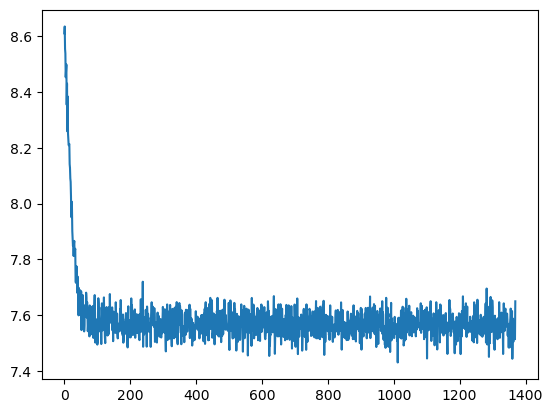

In [152]:
import matplotlib.pyplot as plt
plt.plot(losses)

# test the model

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 86.28it/s]


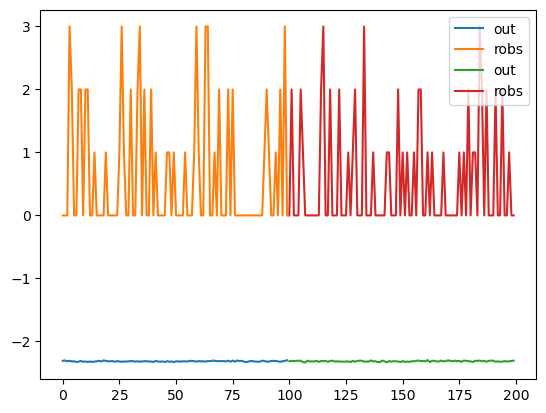

In [158]:
import matplotlib.pyplot as plt

outs = []
robs_sequences = []
for batch in tqdm.tqdm(valid_dl):
    stim_sequence, robs_sequence = batch_to_sequences(batch, device)
    if stim_sequence is None:
        continue
    robs_sequences.append(robs_sequence)
    out = model(stim_sequence)
    outs.append(out)
    
# normalize the outputs and robs
# normalized_outs = []
# normalized_robs_sequences = []
# for out, robs_sequence in zip(outs, robs_sequences):
#     out = out / torch.max(out)
#     robs_sequence = robs_sequence / torch.max(robs_sequence)
#     normalized_outs.append(out)
#     normalized_robs_sequences.append(robs_sequence)

i = 100
for out, robs_sequence in zip(outs, robs_sequences):
    plt.plot(range(i-100,i), out[0,:,1].cpu().detach().numpy(), label='out')
    plt.plot(range(i-100,i), robs_sequence[0,:,1].cpu().detach().numpy(), label='robs')
    i += 100
    if i > 200: break
plt.legend()